In [1]:
#inporting libraries

In [4]:
import os
import numpy as np
import keras
from keras.models import Sequential,Model
from keras.layers import Input,Dense,Conv2D,BatchNormalization,Dropout,Flatten
from keras.layers import Activation,Reshape,Conv2DTranspose,UpSampling2D
from keras.optimizers import RMSprop

import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#loading Data

In [6]:
input_image='apple.npy'

In [7]:
data=np.load(input_image)

In [12]:
#data[6]

In [13]:
data.shape # viewing the shape of the data

(144722, 784)

#reshaping

In [14]:
data=data/255
data=np.reshape(data,(data.shape[0],28,28,1))

In [16]:
#data.shape
img_width,img_height=data.shape[1:3]

In [17]:
img_width

28

In [18]:
#plotting the image


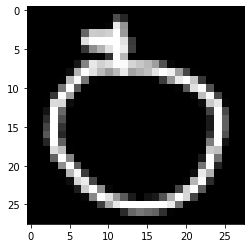

In [22]:
plt.imshow(data[6,:,:,0],cmap='gray')

##Creating Discriminator

In [27]:
def discriminator_builder(width=64,p=0.4):
    # here 64 refer the 64 features or corners
    #p =0.p i.e drop out is 40%
    inputs=Input((img_width,img_height,1))
    #convolution layer
    L1=Conv2D(width*1,5,strides=2,padding='same',activation='relu')(inputs)
    L1=Dropout(p)(L1)
    
    L2=Conv2D(width*2,5,strides=2,padding='same',activation='relu')(L1)
    L2=Dropout(p)(L2)
    
    L3=Conv2D(width*3,5,strides=1,padding='same',activation='relu')(L2)
    L3=Dropout(p)(L3)
    
    L4=Conv2D(width*8,5,strides=1,padding='same',activation='relu')(L3)
    L4=Flatten()(Dropout(p)(L4))
    
    #output Layer
    output=Dense(1,activation='sigmoid')(L4)
    
    #model Defination
    model=Model(inputs=inputs,outputs=output)
    model.summary()
    keras.utils.plot_model(model,'discre.png',show_shapes=True)
    return model
    


In [28]:
#call discriminator builder

In [29]:
discriminator=discriminator_builder()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 192)         614592    
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 192)         0   

In [30]:
#compiling the Discriminator

In [32]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=0.0008,
                                        decay=6e-8,clipvalue=1.0),
                     metrics=['accuracy'])
#decay: factor that helps to decrease learning rate 
        #in each iteration to make system more accurate
#clipvalue:if the gradient is higher than 1 then 
        #clipvalue helps to make it equal to 1

###Defining the Generator builder

In [38]:
def generator_builder(Z_dims=100,width=64,p=0.4):
    #latent space with dimension 100 with required feature in vector form
    #64 conrner with 40% dropout
    inputs=Input((Z_dims,))
    # steps in generation is inverse of classification
    #i.e desnse----->Dconvolution------>Image Generation
    
    #first layer
    D1=Dense(7*7*64)(inputs)
    D1=BatchNormalization(momentum=0.9)(D1)
    #normalize the weights in the layers of the Neural Nets
    #Momentum varies the weights with eachother of 90%
    D1=Activation(activation='relu')(D1)
    D1=Reshape((7,7,64))(D1)
    D1=Dropout(p)(D1)
    
    #deconvolution
    C1=UpSampling2D()(D1)# it helps to double the dimension
    C1=Conv2DTranspose(32,kernel_size=5,padding='same',activation=None)(C1)
    C1=BatchNormalization(momentum=0.9)(C1)
    C1=Activation(activation='relu')(C1)
    
    C2=UpSampling2D()(C1)# it helps to double the dimension
    C2=Conv2DTranspose(32,kernel_size=5,padding='same',activation=None)(C2)
    C2=BatchNormalization(momentum=0.9)(C2)
    C2=Activation(activation='relu')(C2)
    
    C3=Conv2DTranspose(32,kernel_size=5,padding='same',activation=None)(C2)
    C3=BatchNormalization(momentum=0.9)(C3)
    C3=Activation(activation='relu')(C3)
    
    #outputlayer
    output=Conv2D(1,kernel_size=5,padding='same',activation='sigmoid')(C3)
    
    model=Model(inputs=inputs,outputs=output)
    model.summary()
    keras.utils.plot_model(model,'gene.png',show_shapes=True)
    return model

In [34]:
#Calling Generator


In [39]:
generator=generator_builder()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_6 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_6 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 64)        0   

In [40]:
#defining the Adverserial Network

In [41]:
def adverserial_builder(Z_dims=100):
    #model Creation
    model=Sequential()
    #adding Generator
    model.add(generator)
    #adding Discriminator
    model.add(discriminator)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.0004,decay=3e-8,clipvalue=1.0),
                 metrics=['accuracy'])
    model.summary()
    keras.utils.plot_model(model,'advers.png',show_shapes=True)
    return model

In [42]:
adverserial=adverserial_builder()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 28, 28, 1)         432961    
_________________________________________________________________
model_2 (Model)              (None, 1)                 3304385   
Total params: 3,737,346
Trainable params: 3,730,882
Non-trainable params: 6,464
_________________________________________________________________


In [43]:
#training model


In [44]:
def make_trainable(net,val):
    net.trainable=val
    for l in net.layers:
        l.tranable=val

In [62]:
def train(epochs=5,batch=128):
    #Dicriminator matric
    d_metrics=[]
    #Adverserial matrics
    a_metrics=[]
    
    running_d_loss=0
    running_d_accuracy=0
    
    running_a_loss=0
    running_a_accuracy=0
    #Starting of training epochs
    for i in range(1,epochs):
        real_imgs=np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],
                             (batch,28,28,1))
        fake_imgs=generator.predict(np.random.uniform(-1.0,1.0,size=[batch,100]))
        x=np.concatenate((real_imgs,fake_imgs))
        y=np.ones([2*batch,1])
        y[batch:,:]=0
        
        #training the Discriminator
        make_trainable(discriminator,True)
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss +=d_metrics[-1][0]
        running_d_accuracy +=d_metrics[-1][1]
        
        #now we beging the training of generator
        #we must make discriminator fixed
        make_trainable(discriminator,False)
        
        
        # creating the latent space/noise
        noise=np.random.uniform(-1.0,1.0,size=[batch,100])
        y=np.ones([batch,1])
        #appending metrices for advertial network
        a_metrics.append(adverserial.train_on_batch(noise,y))
        running_a_loss+=a_metrics[-1][0]
        running_a_accuracy+=a_metrics[-1][1]
        if (i%10)==0:
            print('Epoch#{}'.format(i+1))
            log_msg='%d:[DLoss:%f,acc:%f]'%(i,running_d_loss/(i),
                                            running_d_accuracy/(i))
            log_msg='%s:[ALoss:%f,acc:%f]'%(log_msg,running_a_loss/(i),
                                            running_a_accuracy/(i))
            print(log_msg)
            noise=np.random.uniform(-1.0,1.0,size=[16,100])
            gen_images=generator.predict(noise)
            plt.figure(figsize=(5,5))
            for k in range(gen_images.shape[0]):
                plt.subplot(4,4,k+1)
                plt.imshow(gen_images[k,:,:,0],cmap='gray')
                plt.axis('off')
            plt.tight_layout()
            plt.show()
    return a_metrics,d_metrics
    

C:\Users\SRK\.conda\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\SRK\.conda\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch#11
10:[DLoss:1.244355,acc:0.748047]:[ALoss:0.920867,acc:0.594531]


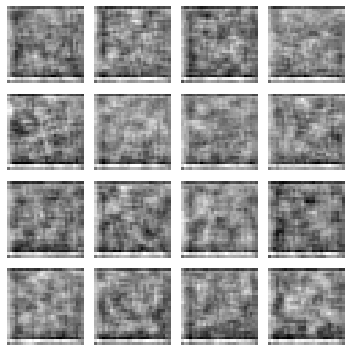

Epoch#21
20:[DLoss:0.622181,acc:0.874023]:[ALoss:0.460604,acc:0.797266]


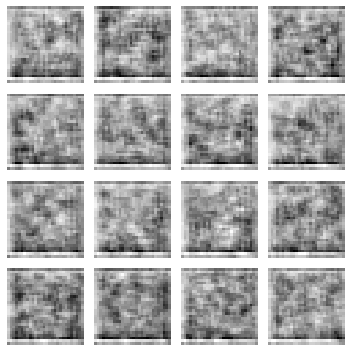

In [63]:
a_metrics_complete,d_metrics_complete=train(30)

In [64]:
adverserial.save('addd.model')
discriminator.save('deddd.model')
generator.save('geddd.model')

In [65]:
generator=keras.models.load_model('geddd.model')


C:\Users\SRK\.conda\envs\tensorflow\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [66]:
noise=np.random.uniform(-1.0,1.0,size=[16,100])
gen_images=generator.predict(noise)
plt.figure(figsize=(5,5))

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

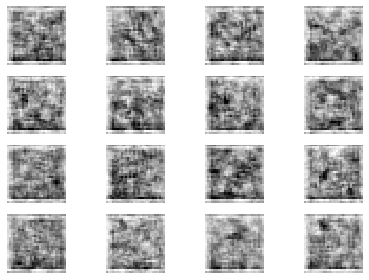

In [69]:
for k in range(gen_images.shape[0]):
    plt.subplot(4,4,k+1)
    plt.imshow(gen_images[k,:,:,0],cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Loss')

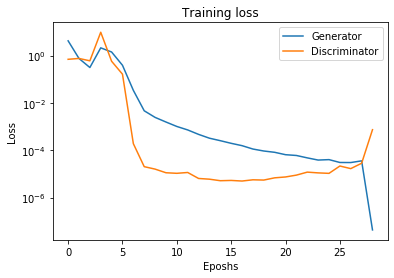

In [71]:
ax=pd.DataFrame({
    'Generator':[metric[0] for metric in a_metrics_complete],
    'Discriminator':[metric[0] for metric in d_metrics_complete]
}).plot(title="Training loss",logy=True)
ax.set_xlabel("Eposhs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

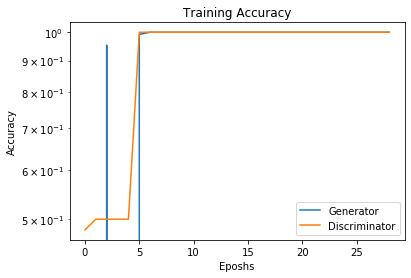

In [72]:
ax=pd.DataFrame({
    'Generator':[metric[1] for metric in a_metrics_complete],
    'Discriminator':[metric[1] for metric in d_metrics_complete]
}).plot(title="Training Accuracy",logy=True)
ax.set_xlabel("Eposhs")
ax.set_ylabel("Accuracy")